In [47]:
# for colab add this (some of them must replace)

# pip install jalali_pandas
# from google.colab import drive
# drive.mount('/content/drive')
# dollor = pd.read_excel('/content/drive/MyDrive/Marketcap Charts/dollor.xlsx')
# Mcap =  pd.read_excel('/content/drive/MyDrive/Marketcap Charts/marketcap.xlsx')

import numpy as np
import pandas as pd
import jalali_pandas
from datetime import datetime,date
import matplotlib.pyplot as plt

dollor = pd.read_excel('./dollor.xlsx')
Mcap =  pd.read_excel('./marketcap.xlsx')

dollor.rename(columns = {'تاریخ':'DATE', 'دلار':'dollorRate'}, inplace = True)
dollor['DATE'] = dollor['DATE'].str.replace('-','/')
dollor["DATE"] =dollor["DATE"].jalali.parse_jalali("%Y/%m/%d")
dollor["DATE"] = dollor["DATE"].jalali.to_gregorian()
Mcap.drop(['ClosePrice', 'last Capital'], axis=1,inplace=True)
Mcap.rename(columns = {'market cap':'MarketCap'}, inplace = True)
Mcap = Mcap.dropna(subset=['MarketCap'])
Mcap.drop(Mcap.index[Mcap['MarketCap'] == '#VALUE!'], inplace=True)
Mcap.sort_values(by=['ShortName','DateTimeEn'], inplace=True)
Mcap.MarketCap = pd.to_numeric(Mcap.MarketCap)
Mcap['DateTimeEn'] = pd.to_datetime(Mcap['DateTimeEn']).dt.date
Mcap['DateTimeEn'] = pd.to_datetime(Mcap['DateTimeEn'], format='%Y-%m-%d')
Mcap = Mcap.query(" DateTimeEn >= '2009-03-01'" )
Mcap.reset_index(drop=True, inplace=True)
mean_dollor = dollor.groupby(pd.PeriodIndex(dollor['DATE'], freq="M"))['dollorRate'].mean().reset_index()
mean_cap = Mcap.groupby(['ShortName', pd.Grouper(key='DateTimeEn', freq='M')])['MarketCap'].mean().reset_index()
mean_cap['DateTimeEn'] = mean_cap['DateTimeEn'].dt.to_period('M')

# create a column by divide a marketcap / dollor rate
for index, row in mean_cap.iterrows():
    mean_cap.loc[index,'MarketCapindollor'] = row['MarketCap']/mean_dollor[mean_dollor['DATE'] == row['DateTimeEn']]['dollorRate'].values

##برای تغییر سهم فقط قسمت دوم را مجددا اجرا کنید





/tmp/ipykernel_17454/351830523.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saham["DateTimeEn"] = saham["DateTimeEn"].astype("datetime64[ns]")


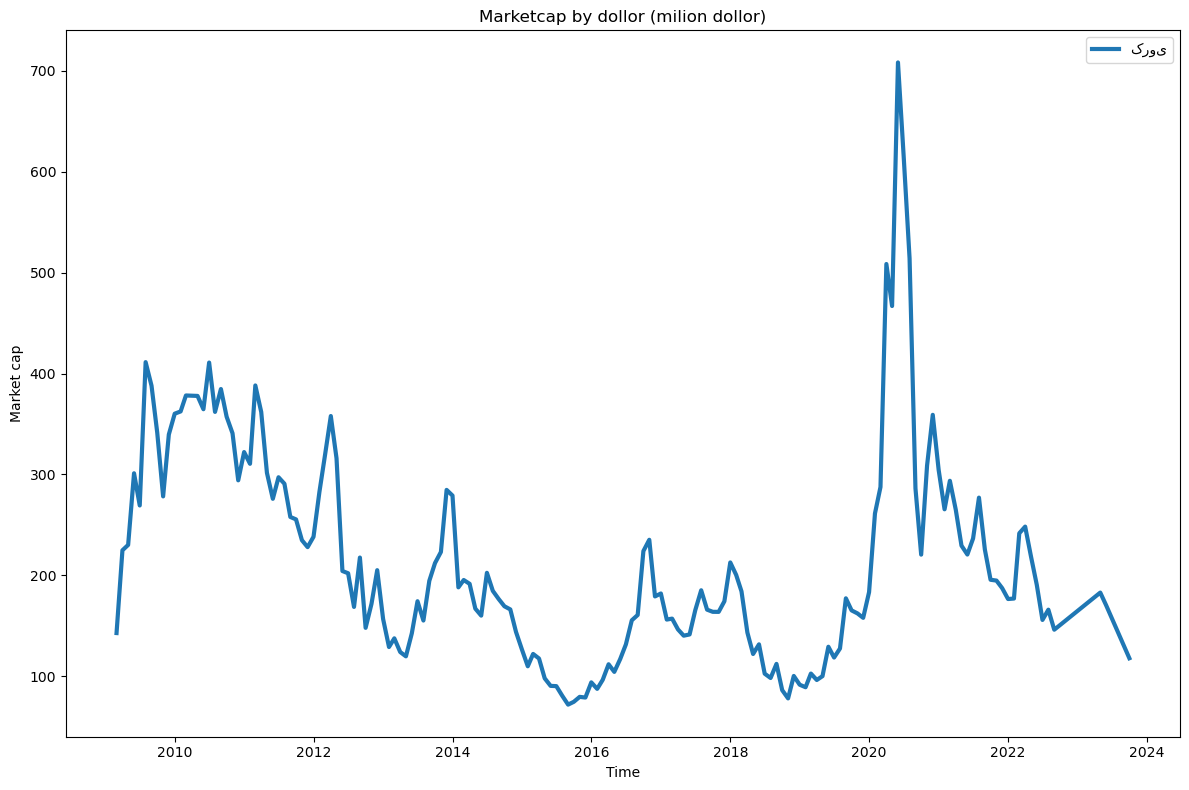

In [59]:
saham_name = input("نماد سهام مورد نظر را وارد کنید")
saham = mean_cap[mean_cap['ShortName'] == saham_name ]

saham["DateTimeEn"] = saham["DateTimeEn"].astype("datetime64[ns]")

fig = plt.figure(figsize=(12, 8))
plt.plot(saham.DateTimeEn, saham.MarketCapindollor/1000000, label=saham_name,
         linewidth=3)

# Add title and labels

plt.title('Marketcap by dollor (milion dollor)')
plt.xlabel('Time')
plt.ylabel('Market cap')

# Add legend

plt.legend()

# Auto space

plt.tight_layout()

# Display plot